<a href="https://colab.research.google.com/github/JeremyKrick/Predictive-Analytics-for-Store-Performance/blob/jeremy_dev/Store_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Statement And Justification For The Proposed Approach

Predictive Analytics for Store Performance: Our goal is to help in understanding what factors contribute to a store's performance, and strategic decisions could be made based on this. For example, if distance to the nearest competitor significantly affects sales, then this could be considered when opening new stores. A regression model like Random Forest Regressor, Gradient Boosting Regressor or a Neural Network Regressor could be used for this purpose. The "Sales" column would be the target variable, and all the other columns would be considered as features. Features could be engineered and selected using a variety of techniques, and the model could be evaluated using metrics like Root Mean Squared Error (RMSE) or Mean Absolute Percentage Error (MAPE).

### Data Processing

In [ ]:
#@title Loading the required libraries
import pandas as pd # Pandas for data manipulation
import seaborn as sns # Seaborn for visualizing. Note: we will also use one of the data sets
import matplotlib.pyplot as plt # Matplotlib for subplots
%matplotlib inline

from sklearn.model_selection import train_test_split,  RandomizedSearchCV # Import train_test_split function
from sklearn import metrics, svm # Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Import for feature standardization
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#@title Mounting your Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
#@title Load df
df = pd.read_csv("/content/drive/My Drive/AAI 510/Team 6/rossmann-store-sales/train.csv", sep=",", low_memory=False)

df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,7/31/2015,5263,555,1,1,0,1
1,2,5,7/31/2015,6064,625,1,1,0,1
2,3,5,7/31/2015,8314,821,1,1,0,1
3,4,5,7/31/2015,13995,1498,1,1,0,1
4,5,5,7/31/2015,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,1/1/2013,0,0,0,0,a,1
1017205,1112,2,1/1/2013,0,0,0,0,a,1
1017206,1113,2,1/1/2013,0,0,0,0,a,1
1017207,1114,2,1/1/2013,0,0,0,0,a,1


### Data Understanding (EDA)

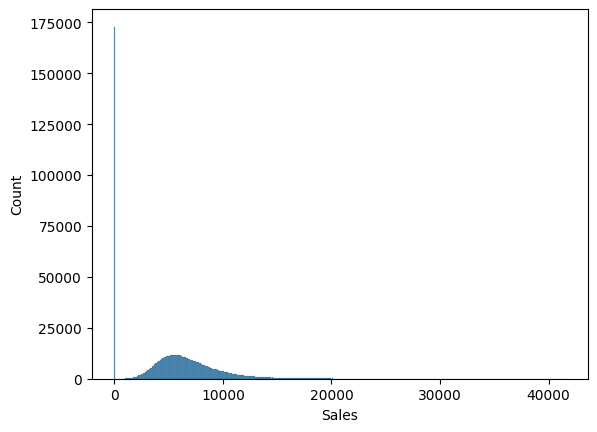

In [14]:
#@title Visualize Sales Distribution
#Histogram
sns.histplot(data=df, x='Sales')
plt.show()

In [15]:
#@title 10% subset of df
df2 = df.sample(frac=0.10, random_state=42)
df2.shape

(101721, 9)

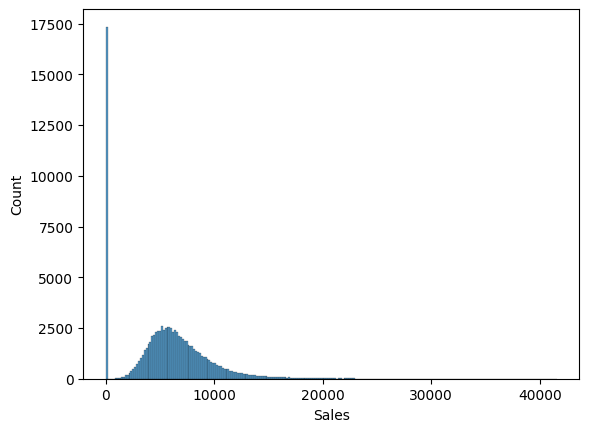

In [17]:
#@title Visualize Sales Distribution After 10% Sampling
#Histogram
sns.histplot(data=df2, x='Sales')
plt.show()

### Data Preparation

In [ ]:
#@title Splitting Dataset into Training Set and Test Set
y = df2.Sales # Predict Sales
X = df2.drop(columns=['Sales'])

#Split dataset

### Feature Engineering

### Feature Selection

### Modeling

### Evaluation

### Discussion and Conclusions